In [152]:
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from itertools import product

sns.set()

<img src="https://cdn-images-1.medium.com/max/800/1*Y2KPVGrVX9MQkeI8Yjy59Q.gif">

## Let's start with Exponentially Weighted Averages

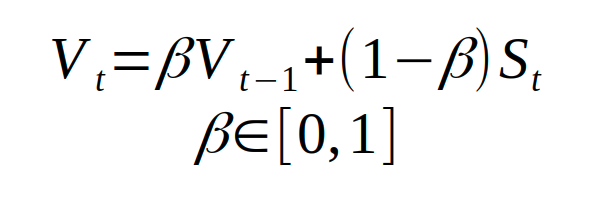

#### Generate dataset

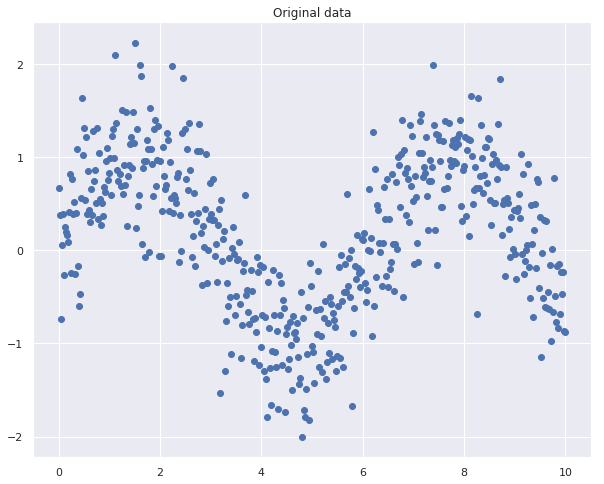

In [430]:
np.random.seed(10)
x = np.linspace(0,10,500)
S = np.sin(x) + np.random.normal(0,0.5,500)
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x,S)
ax.set_title("Original data");

#### Transforme dataset 

In [428]:
def EWA_transform(S,betta):
    """
    EWA transforme
    """
    V = [0]
    for i in range(1,len(S)):
        V.append((betta*V[-1] + (1-betta)*S[i]))
    return V


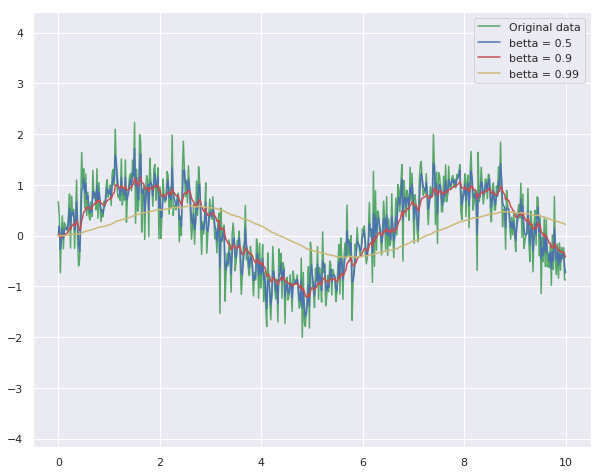

In [429]:
V_1 = EWA_transform(S,0.5)
V_2 = EWA_transform(S,0.9)
V_3 = EWA_transform(S,0.99)
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x, S, '-g', label='Original data')
ax.plot(x, V_1, '-b', label='betta = 0.5')
ax.plot(x, V_2, 'r', label='betta = 0.9')
ax.plot(x, V_3, '-y', label='betta = 0.99')
ax.axis('equal')
leg = ax.legend();

### Select function for optimization

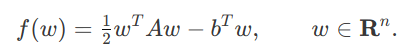

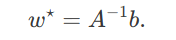

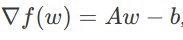

In [325]:
A = np.array([[1,0],[0,1]])
b = np.array([50,25]).reshape(2,1)

def cost(w,A,b):
    return np.asscalar(1/2*np.dot(np.dot(w.T,A),w) - np.dot(b.T,w)) + np.random.normal(0,0.5)

def cost_grad(w,A,b):
    return (np.dot(A,w) - b)

In [193]:
w_0 = np.dot(np.linalg.inv(A),b)
print("Real Minimum point:",w_0.reshape(1,2))
print("Min value:",cost(w_0,A,b))

Real Minimum point: [[50. 25.]]
Min value: -1562.5


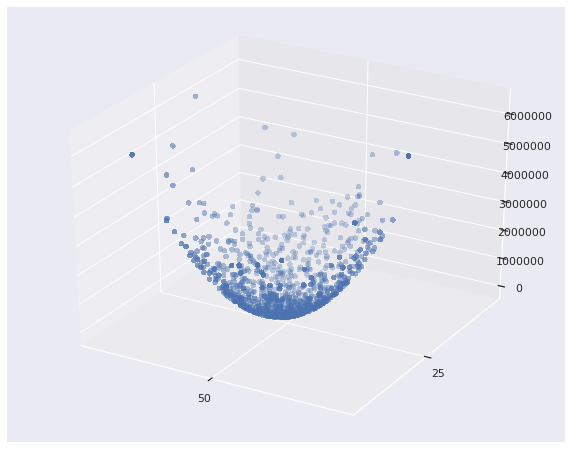

In [431]:
X = np.random.randn(1000,2)*1000
Z = np.array([cost(x.reshape(2,1),A,b) for x in X]).reshape(-1,1)
Z_grad = np.array([cost_grad(x.reshape(2,1),A,b) for x in X]).reshape(-1,1)

fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

ax.scatter(X[:,0], X[:,1], Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xticks(w_0[0])
ax.set_yticks(w_0[1]);

### Gradient Descent 

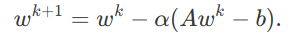

In [404]:
class Gradient_Descent():
    """
    Simple Gradient Descent
    """
    def __init__(self,**kwargs):
        self.cost = kwargs["cost"]
        self.cost_grad = kwargs["cost_grad"]
        self.lr = kwargs["lr"]
        self.epochs = kwargs["epochs"]
        self.A = kwargs["A"]
        self.b = kwargs["b"]
        self.w_0 = kwargs["w_0"]
        self.tau = kwargs["tau"]
        self.history = []
    def optimize(self,X):
        w = np.ones((2,1))
        converg = False
        for i in range(self.epochs):
            if not converg:
                for j in range(X.shape[1]):
                    grad = self.cost_grad(X[:,j].reshape(-1,1),self.A,self.b)
                    w -= self.lr*grad
                    self.history.append(cost(w,self.A,self.b))
                    if np.linalg.norm(w-self.w_0)<self.tau:
                        converg = True
                        print("converge in {0} steps".format(len(self.history)))
                        break
            else:
                break
        return w

In [327]:
def plot_results(optimizer,X,**params):
    opt = optimizer(**params)
    w_min = opt.optimize(X)
    print("Real min point:",params["w_0"].reshape(1,2))
    print("Estimated min point:",w_min.reshape(1,2))
    print("Distance:",np.linalg.norm(w_min-w_0))
    steps = np.linspace(0,len(opt.history),len(opt.history))
    plt.plot(steps,opt.history)
    plt.title("History")
    plt.xlabel("Steps")
    plt.ylabel("Cost")
    plt.show();

In [281]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

converge in 11 steps
Real min point: [[50. 25.]]
Estimated min point: [[50.815 22.33 ]]
Distance: 2.791616914979558


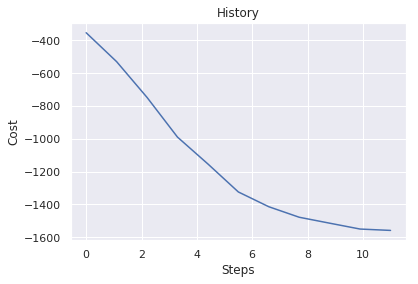

In [403]:
params = {"cost":cost,
          "cost_grad":cost_grad,
          "lr":0.09,
          "epochs":50,
          "w_0":w_0,
          "A":A,
          "b":b,
          "tau":4
}

# np.random.seed(1)
X = np.arange(-25,25,0.5)
Y = np.arange(-25,25,0.5)
X,Y = np.meshgrid(X,Y)
data = np.vstack([X.ravel(), Y.ravel()])
data = shuffle_along_axis(data,axis=1)

plot_results(Gradient_Descent,data,**params)

### Mini-Batch Stochastic Gradient Descent

In [417]:
class SGD():
    """
    Stochastic Gradient Descenet 
    
    """
    def __init__(self,**kwargs):
        self.cost = kwargs["cost"]
        self.cost_grad = kwargs["cost_grad"]
        self.lr = kwargs["lr"]
        self.epochs = kwargs["epochs"]
        self.A = kwargs["A"]
        self.b = kwargs["b"]
        self.w_0 = kwargs["w_0"]
        self.tau = kwargs["tau"]
        self.batch_size = kwargs["batch_size"]
        self.step_size = kwargs["step_size"]
        self.history = []
        
        
    def optimize(self,X):
        w = np.zeros((2,1))
        converg = False
        for i in range(self.epochs):
            if not converg:
                for j in range(X.shape[1]):
                    batch = X[:,np.random.randint(0,X.shape[1],self.batch_size)]
                    grad = np.zeros((2,1))
                    for t in range(self.batch_size):
                        grad += self.cost_grad(batch[:,t].reshape(-1,1),self.A,self.b)
                    grad = grad/self.batch_size
                    w -= self.lr*grad
                    self.history.append(cost(w,self.A,self.b))
                    if np.linalg.norm(w-self.w_0)<self.tau:
                        converg = True
                        print("converge in {0} steps".format(len(self.history)))
                        break
            else:
                break
        return w
    


converge in 10 steps
Real min point: [[50. 25.]]
Estimated min point: [[50.53675 24.438  ]]
Distance: 0.7771387022276102


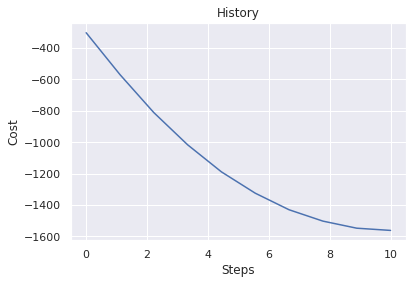

In [425]:
sgd_params = {"cost":cost,
              "cost_grad":cost_grad,
              "lr":0.1,
              "epochs":1000,
              "w_0":w_0,
              "A":A,
              "b":b,
              "tau":1,
              "batch_size":200,
              "step_size":100
}

X = np.arange(-25,25,0.5)
Y = np.arange(-25,25,0.5)
X,Y = np.meshgrid(X,Y)
data = np.vstack([X.ravel(), Y.ravel()])
data = shuffle_along_axis(data,axis=1)

plot_results(SGD,data,**sgd_params)

## SGD with momentum

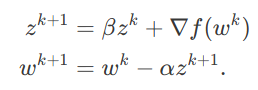

In [374]:
class SGD_momentum():
    """
    Stochastic Gradient Descenet whit momentum
    
    """
    def __init__(self,**kwargs):
        self.cost = kwargs["cost"]
        self.cost_grad = kwargs["cost_grad"]
        self.lr = kwargs["lr"]
        self.betta = kwargs["betta"]
        self.epochs = kwargs["epochs"]
        self.A = kwargs["A"]
        self.b = kwargs["b"]
        self.w_0 = kwargs["w_0"]
        self.tau = kwargs["tau"]
        self.batch_size = kwargs["batch_size"]
        self.step_size = kwargs["step_size"]
        self.history = []
        
        
    def optimize(self,X):
        w = np.zeros((2,1))
        z = np.zeros((2,1))
        converg = False
        for i in range(self.epochs):
            if not converg:
                for j in range(X.shape[1]):
                    batch = X[:,np.random.randint(0,X.shape[1],self.batch_size)]
                    grad = np.zeros((2,1))
                    for t in range(self.batch_size):
                        grad += self.cost_grad(batch[:,t].reshape(-1,1),self.A,self.b)
                    grad = grad/self.batch_size
                    z = self.betta*z + (1-self.betta)*grad
                    w -= self.lr*z
                    self.history.append(cost(w,self.A,self.b))
                    if np.linalg.norm(w-self.w_0)<self.tau:
                        converg = True
                        print("converge in {0} steps".format(len(self.history)))
                        break
            else:
                break
        return w
    


converge in 15 steps
Real min point: [[50. 25.]]
Estimated min point: [[49.91854947 25.81866001]]
Distance: 0.8227018905187884


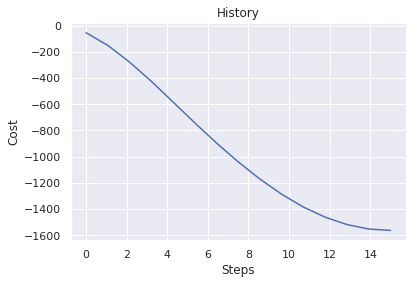

In [402]:
momentum_params = {"cost":cost,
              "cost_grad":cost_grad,
              "lr":0.09,
              "betta":0.8,
              "epochs":1000,
              "w_0":w_0,
              "A":A,
              "b":b,
              "tau":2,
              "batch_size":200,
              "step_size":100
}

X = np.arange(-25,25,0.5)
Y = np.arange(-25,25,0.5)
X,Y = np.meshgrid(X,Y)
data = np.vstack([X.ravel(), Y.ravel()])
data = shuffle_along_axis(data,axis=1)

plot_results(SGD_momentum,data,**momentum_params)